## Exploratory Data Analysis

### Import libraries


In [1]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from ipywidgets import interactive, widgets, interact

import warnings
warnings.filterwarnings('ignore')

### Load the data

We scraped the data from the web and extracted only the relevant csv files. We have decided to focus on 4 languages: English, French, German and Italian. Furthermore, we included the data of all available languages on twitch.tv together.

In [2]:
def load_data(path, language = ""):
    filenames = glob.glob(path + "/*.csv")
    dfs = []
    for filename in filenames:
        dfs.append(pd.read_csv(filename))

    # concatenate all data into one DataFrame
    df = pd.concat(dfs, ignore_index=True).dropna(axis=1)
    # drop empty and single value columns 
    df = df.loc[:,df.apply(pd.Series.nunique) != 1]
    # create a datetime column
    df["date"] = pd.to_datetime(df['year'].astype(str)  + df['month'], format='%Y%B')
    df = df.drop(['year', 'month'], axis=1)
    df = df.rename(columns={"url": "channel"})
    
    # Select only relevant columns
    df_final = df[["channel", "date", "viewminutes"]]
    
    # Add language
    if language != "": df_final["language"] = language 
    
    
    return df_final

In [3]:
all_ = load_data(r'./All')

In [ ]:
english = load_data(r'./English', 'English')
french = load_data(r'./French', 'French')
german = load_data(r'./German', 'German')
italian = load_data(r'./Italian', 'Italian')

# For chess we need the data with the languages annotated
en_fr_ge_it = english.append(german).append(french).append(italian)
en_fr_ge_it = en_fr_ge_it.set_index(np.arange(len(en_fr_ge_it)))

### Some basic stats about our dataset (all languages together)

We will mainly focus on the column **viewminutes**. Here is a random subset of our data:

In [4]:
all_.groupby(["date", "channel"]).sum().sample(5).sort_values(by=["viewminutes"], ascending = False)

,,viewminutes
date,channel,
2017-12-01,Car_Mechanic_Simulator_2018,660300
2016-04-01,Sex_Olympics,10800
2020-12-01,Solomons_Key,480
2016-06-01,Europa_Universalis_III,180
2020-12-01,Coloring_Game_Pixel,120


To better understand the magnitude of the viewminutes, we also show the statistics on a logscale (logviewminutes).
In this summary we see that in the month with the most viewminutes, the amount of watched minutes were $~2\cdot e^{10}$. Half of the available months have $~1.8\cdot e^3$ or less viewminutes. This statistics hint at a skewed distribution.

In [5]:
all_["logviewminutes"] = np.log10(all_['viewminutes']+1)
all_.describe()

,viewminutes,logviewminutes
count,8.700180e+05,870018.000000
mean,2.773313e+06,3.408348
std,9.441072e+07,1.474189
min,0.000000e+00,0.000000
25%,3.000000e+02,2.478566
50%,1.800000e+03,3.255514
75%,1.920000e+04,4.283324
max,2.067312e+10,10.315406


Visualising the viewminutes distribution (on a log scale), we notice indeed a skewed distribution:

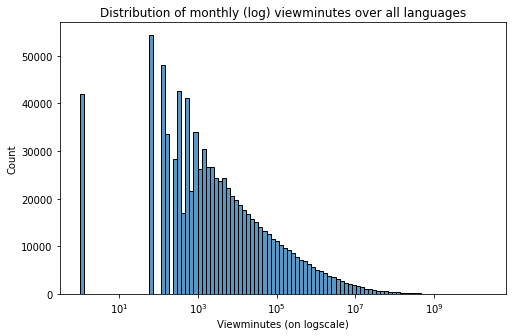

In [6]:
f, ax = plt.subplots(figsize=(8, 5))
all_["viewminutes"] = all_["viewminutes"].map(lambda x: x+1)
sns.histplot(data = all_, x = "viewminutes", log_scale = True, ax = ax, bins = 100)
ax.set_title("Distribution of monthly (log) viewminutes over all languages")
ax.set_xlabel("Viewminutes (on logscale)");

Here we glance into our most recent data, to get an idea what kind of channels seem to be super popular:

In [7]:
all_.groupby(["date", "channel"]).sum().sort_values(by=["date", "viewminutes"], ascending = False).head(5)

viewminutes  logviewminutes
date       channel                                                 
2021-03-01 Just_Chatting                16223722141       10.210150
           Grand_Theft_Auto_V           11074670281       10.044331
           League_of_Legends             8987191081        9.953624
           Fortnite                      7040576821        9.847608
           Call_of_Duty_Modern_Warfare   5456146921        9.736886

### Extract the n most popular channels over all languages

We decided to only focus on the most popular channels across all languages, but we are aware that this favours the popular channels among the english speaking languages, since they dominate the viewminutes.

In [ ]:
def get_n_most_popular(df, n = 5, language = True):
    
    # Get the top n channels of all languages together
    top_n = all_.groupby("channel").sum()["viewminutes"].sort_values(ascending=False).head(n)
    top_n = list(top_n.index.values)
    
    # Extract the relevant data rows containing information about the top channels
    if language:
        temp = df[df['channel'].isin(top_n)][['viewminutes','date','channel', 'language']].sort_values(by=["channel"])
    else:
        temp = df[df['channel'].isin(top_n)][['viewminutes','date','channel']].sort_values(by=["channel"])
        
    log_x=True
    return temp

In [ ]:
n = 5
pop_en_fr_ge = get_n_most_popular(en_fr_ge_it, n)
pop_all = get_n_most_popular(all_, n, language = False)
pop_all['language'] = "All"

# append for plotting
pop = pop_en_fr_ge.append(pop_all)

### Plot timeseries of most popular channels

We will plot our data in an interactive way. To see the plot, just select your desired language in the box, or choose "All" to see the timeseries over all languages. You can hover over the graph to inspect it in more detail.

In [ ]:
def plot_most_popular(language):
    if not language:
        return
    
    # wrangle dataframe for plotting
    df = pop[pop.language.isin([language[0]])]
    df = df.drop_duplicates(keep='first')
    df = df.pivot(index='date', columns='channel', values = 'viewminutes')
    
    # set up the plotly figure
    fig = px.line(df)
    fig.update_layout(hovermode="x")
    fig.update_layout(
    title=f"Viewminutes of the most popular channels on Twitch.tv in {language[0]}",
    xaxis_title="Year",
    yaxis_title="Viewminutes",
    legend_title="Channel",
    )
    
    # indicate the lockdown start italy with a vertical line
    fig.add_vline(x="2020-03-09")
    fig.add_annotation(
    x="2020-03-09",
    y=100,
    text="Lockdowns in Europe start",
    textangle=-90
    )
    
    fig.show()

In [ ]:
language_selector = widgets.SelectMultiple(
    options = np.sort(pop.language.unique()),
    description = 'Languages: '
)

_ = interact(plot_most_popular, language = language_selector)

### Plot timeseries of chess

We are also interested in how the chess channel developed over the years. We hypothesize, that the corona lockdowns (first was in Italy on 09.03.2020) and the release of the TV show "Queen's Gambit" (23.10.2020) have influenced its popularity, so we will mark these dates with a vertical line in our plot.

In [ ]:
def plot_chess(df):
    chess_s = df[df["channel"] == 'Chess'][["viewminutes", "date", 'language']]
    chess_s = chess_s.sort_values(by=["date"])#.set_index("date")
    chess_s = chess_s.drop_duplicates(keep='first')
    chess_s = chess_s.pivot(index='date', columns='language', values = 'viewminutes')
    
    # compute over all languages
    chess_a = all_[all_["channel"] == 'Chess']
    chess_a = chess_a.sort_values(by=["date"])#.set_index("date")
    chess_a = chess_a.drop_duplicates(keep='first')
    chess_a = chess_a.pivot(index='date', columns='channel', values = 'viewminutes')
    
    # merge and reorder and rename for plotting
    chess = pd.merge(chess_s, chess_a, left_index = True, right_index = True)
    chess = chess.rename({"Chess":"All"}, axis='columns')
    chess = chess[["All", "English", "French", "German", "Italian"]]
    
    fig = px.line(chess)
    fig.update_layout(hovermode="x")
    fig.update_layout(
    title=f"Viewminutes of the Chess channel on Twitch.tv in different languages",
    xaxis_title="Year",
    yaxis_title="Viewminutes",
    legend_title="Language",
    )
    
    # day of Queen's Gambit TV Show release (23.10.2020)
    fig.add_vline(x="2020-10-23")
    fig.add_annotation(x="2020-10-23", y=100,
            text="Release of Queen's Gambit",
            textangle=-90)
    
    # lockdown start italy (09.03.2020)
    fig.add_vline(x="2020-03-09")
    fig.add_annotation(
    x="2020-03-09",
    y=100,
    text="Lockdowns in Europe start",
    textangle=-90
    )
    return fig

In [ ]:
chess_fig = plot_chess(en_fr_ge_it)
chess_fig